In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
# Hardcode all variables
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
predict_values_exp = 48
lag_exp=24

In [3]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [7]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [8]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [9]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [10]:
''' Loading data '''
import pandas as pd
series = pd.read_excel('AL_WIND_07_12.xlsx',index_col="DateTime")
series.head()

,Air temperature | ('C),Pressure | (atm),Wind speed | (m/s),Wind direction | (deg),Power generated by system | (kW)
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


In [11]:
'''Drop all the features as we will not be having any in production'''
del series['Air temperature | (\'C)']
del series['Pressure | (atm)']
del series['Wind speed | (m/s)']
del series['Wind direction | (deg)']
series.head()

,Power generated by system | (kW)
DateTime,
2007-01-01 00:00:00,33688.1
2007-01-01 01:00:00,37261.9
2007-01-01 02:00:00,30502.9
2007-01-01 03:00:00,28419.2
2007-01-01 04:00:00,27370.3


In [12]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,Power generated by system | (kW)
DateTime,
2012-12-31 09:00:00,6110.57
2012-12-31 10:00:00,6251.34
2012-12-31 11:00:00,6899.17
2012-12-31 12:00:00,4514.49
2012-12-31 13:00:00,1561.25


In [13]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [14]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [15]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [16]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

Epoch 1/1
52501/52501 [==============================] - 228s 4ms/step - loss: 0.0140
Epoch 1/1
52501/52501 [==============================] - 142s 3ms/step - loss: 0.0137
Epoch 1/1
52501/52501 [==============================] - 134s 3ms/step - loss: 0.0135
Epoch 1/1
52501/52501 [==============================] - 137s 3ms/step - loss: 0.0134
Epoch 1/1
52501/52501 [==============================] - 134s 3ms/step - loss: 0.0133
Epoch 1/1
52501/52501 [==============================] - 143s 3ms/step - loss: 0.0133
Epoch 1/1
52501/52501 [==============================] - 137s 3ms/step - loss: 0.0134


In [51]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Hour=1, Predicted=9421.722809, Expected=5331.850000
Hour=2, Predicted=4806.210966, Expected=1479.590000
Hour=3, Predicted=2070.099177, Expected=0.000000
Hour=4, Predicted=-46.776504, Expected=1699.950000
Hour=5, Predicted=1074.315105, Expected=4932.380000
Hour=6, Predicted=4625.198128, Expected=10551.200000
Hour=7, Predicted=10996.867013, Expected=11277.200000
Hour=8, Predicted=12359.007254, Expected=20258.100000
Hour=9, Predicted=22264.559030, Expected=27235.300000
Hour=10, Predicted=29424.535662, Expected=29297.100000
Hour=11, Predicted=31127.749137, Expected=50140.200000
Hour=12, Predicted=51736.317224, Expected=28258.100000
Hour=13, Predicted=30321.284079, Expected=0.000000
Hour=14, Predicted=2346.145982, Expected=3868.210000
Hour=15, Predicted=5300.908689, Expected=0.000000
Hour=16, Predicted=286.586642, Expected=0.000000
Hour=17, Predicted=77.146869, Expected=0.000000
Hour=18, Predicted=-92.542711, Expected=4135.800000
Hour=19, Predicted=5018.378275, Expected=13607.200000
Hour=20

In [52]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Absolute Percent Error:  40.69007886200861


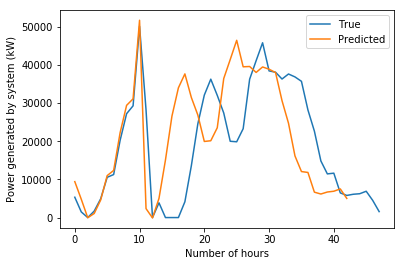

In [53]:
# line plot of observed vs predicted
pyplot.plot(raw_values[-predict_values_exp:], label="True")
pyplot.plot(predictions, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()